# Aim
### The objective of this notebook is to estimate the T1, T2 and PD from the experimental data using the variable projection method for the 2D images.

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
%matplotlib inline

# from bart import bart#required for importing bart
# import cfl #useful in data storage and reading, dont need it right now

In [2]:
pics_out1 = np.load('pics_out_96ETL_experimental_data.npy')
print(pics_out1.shape)

(288, 288, 96)


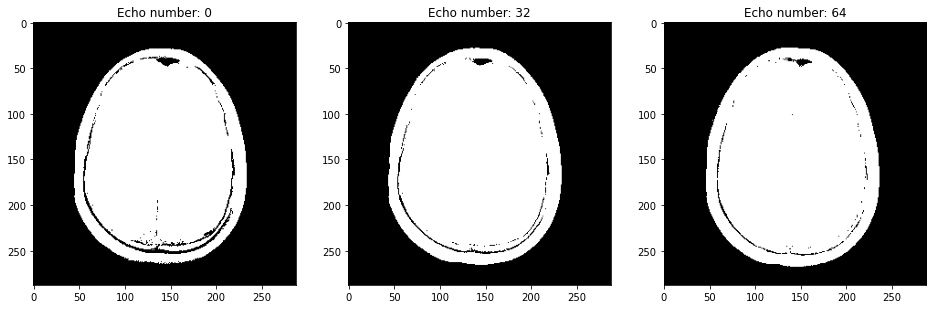

In [3]:
plt.figure(figsize=(16,12))
for index in range(3):
    plt.subplot(1,3,index+1)
    plt.imshow(np.abs(pics_out1[:,:,0+32*index]) > 0.00002, cmap='gray')#,vmax = 800000,vmin=0)
    plt.title('Echo number: ' + str(0+32*index))

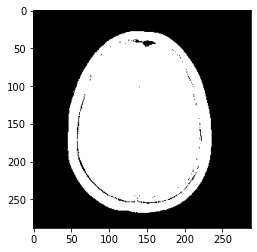

In [4]:
mask = (np.abs(pics_out1[:,:,0+32*index]) > 0.00002)*1 #mask of brain where the actual images is present
plt.imshow(mask, cmap='gray')

In [5]:
np.shape((mask))

(288, 288)

In [6]:
ETL = pics_out1.shape[2]
pics_out = np.zeros(pics_out1.shape, dtype=complex)
signal_evolution = np.zeros((36196,pics_out1.shape[2]), dtype=complex)

for index in range(ETL):
    Im_synthetic = np.zeros([pics_out1.shape[0],pics_out1.shape[1]], dtype=complex)
    data = pics_out1[:,:,index]
    Im_synthetic[np.nonzero(mask)]  = data[np.nonzero(mask)] 
    pics_out[:,:,index] = Im_synthetic
    signal_evolution[:,index] = Im_synthetic[np.nonzero(mask)]
    
    
print(signal_evolution.shape)

(36196, 96)


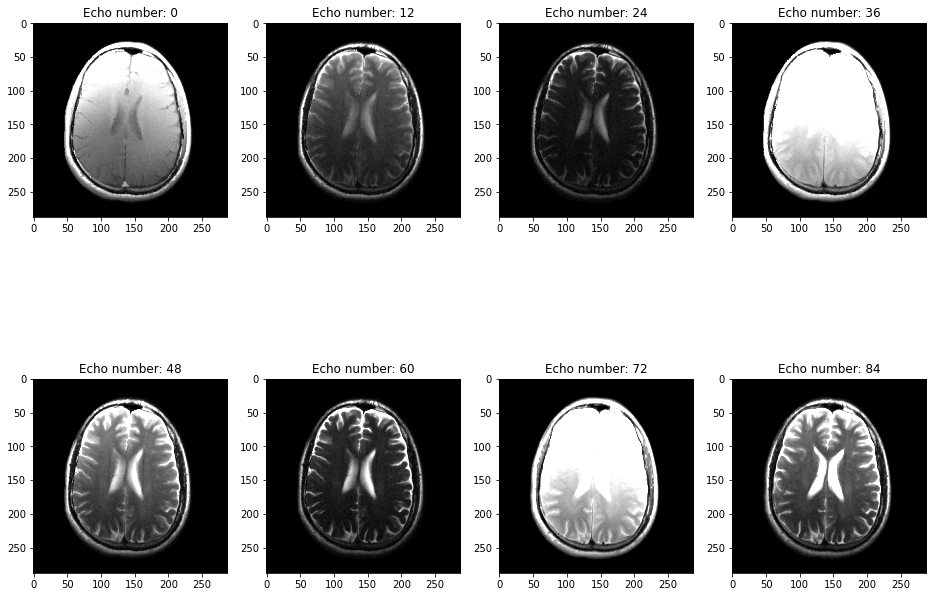

In [7]:
plt.figure(figsize=(16,12))
for index in range(8):
    plt.subplot(2,4,index+1)
    plt.imshow(np.abs(pics_out[:,:,index*12]), cmap='gray',vmax = .0001,vmin=0)
    plt.title('Echo number: ' + str(12*index))

In [8]:
# index1 = 80
# index2 = 80
# plt.plot(np.abs(signal_evolution[20000,:]))#/np.max(np.abs(pics_out[index1,index2,:])))
# plt.show()

In [9]:
# T2_vals = np.load('T2_vals_experimental.npy')#saving the experimental evaluated T2 values
# print(T2_vals.shape)

In [10]:
# Im_synthetic = np.zeros([pics_out1.shape[0],pics_out1.shape[1]], dtype=complex)
# data = pics_out1[:,:,index]
# Im_synthetic[np.nonzero(mask)]  = T2_vals

In [11]:
# plt.imshow(np.abs(Im_synthetic), cmap='gray',vmax = 500,vmin=0)
# plt.title('Estimated T2 map')
# plt.show()

In [12]:
import sys#this helps with reading data from multiple places
# sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
# sys.path.insert(0, 'bart/python')#do we need bart here right now
# sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function
from simulator import FSE_signal, FSE_signal_TR


import torch
import math
from torch.autograd import grad
class LeastSquaresRegressorTorch1():

    def __init__(self, n_iter=10, eta=0.1):
        self.n_iter = n_iter#number of iterations
        self.eta = eta#the step size
        
    def fit(self,  Y, t1, t2):        
        Yt = torch.tensor(Y, dtype=torch.float)#convert numpy to torch data files
        self.t2 = torch.tensor(t2, dtype=torch.float32, requires_grad=True)
        self.t1 = torch.tensor(t1, dtype=torch.float32, requires_grad=True)
        
        self.history = []
        optimizer = torch.optim.SGD([self.t1,self.t2], lr=self.eta)
        ETL = 32#echo train length, 
        TE = 9.1#echo time
        TRs = np.array([860, 1830, 2800])
        self.initial_angle = torch.tensor([180], dtype=torch.float32, requires_grad=True)
        M0 = 1
        angles_rad = torch.tensor( torch.ones((1,ETL))*self.initial_angle*math.pi/180,dtype=torch.float32)
        for i in range(self.n_iter):         
            total_loss = 0
            #print(self.t1,self.t2)
            X_sim_CSF = FSE_signal_TR(angles_rad, TE, TRs, T1=self.t1, T2=self.t2).view(-1, ETL)    # 100x32

            loss = (X_sim_CSF/torch.max(X_sim_CSF)).reshape((1, 3*ETL))  - Yt

            loss_batch = torch.sum(loss**2)    

            optimizer.zero_grad()   # reset all gradients    

            loss_batch.backward()# compute the gradients for the loss for this batch

            optimizer.step()
            total_loss += loss_batch.item()
            self.history.append(total_loss)
            
        #print('SGD-minibatch final loss: {:.4f}'.format(total_loss))
        return self.t1, self.t2, self.initial_angle

/home/ubuntu/anaconda3/envs/code/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([619.4944], requires_grad=True) tensor([79.6818], requires_grad=True) tensor([180.], requires_grad=True)


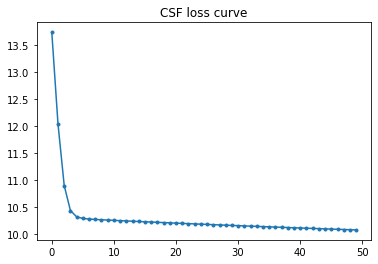

In [13]:
regr = LeastSquaresRegressorTorch1(n_iter=50, eta=1000)

data_avg_CSF = np.abs(signal_evolution[20000,0:96])

t1_CSF, t2_CSF, initial_angle_CSF = regr.fit(data_avg_CSF/np.max(data_avg_CSF), t1 = [500], t2=[200])
print(t1_CSF,t2_CSF,initial_angle_CSF)
plt.plot(regr.history, '.-');
plt.title('CSF loss curve')
plt.show()

In [ ]:
regr = LeastSquaresRegressorTorch1(n_iter=20, eta=10000)

T1_vals = np.zeros((signal_evolution.shape[0]))
T2_vals = np.zeros((signal_evolution.shape[0]))

for index in tqdm(range(signal_evolution.shape[0])):
    data_avg_CSF = np.abs(signal_evolution[index,0:96])
    t1_CSF, t2_CSF, initial_angle_CSF = regr.fit(data_avg_CSF/np.max(data_avg_CSF), t1 = [1000], t2=[100])
    
    T1_vals[index] = t1_CSF
    T2_vals[index] = t2_CSF
    
#     if(index%1000 == 0):
#         print(index)

    #print(t2_CSF,initial_angle_CSF)
#plt.plot(regr.history, '.-');
#plt.title('CSF loss curve')
#plt.show()

  0%|          | 20/36196 [00:12<6:18:20,  1.59it/s]

In [ ]:
Im_synthetic1 = np.zeros([pics_out1.shape[0],pics_out1.shape[1]])
Im_synthetic1[np.nonzero(mask)] = T1_vals

In [ ]:
plt.imshow(Im_synthetic1, cmap=‘gray’,vmax = 8000, vmin=100)
plt.title(‘T1 map’)

In [ ]:
#np.save('T2_vals_experimental.npy',T2_vals)#saving the experimental evaluated T2 values